In [1]:
import numpy as np
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

import torch
from torch import optim

from tqdm import tqdm
import matplotlib.pyplot as plt

from vbsbm import VBSBM

/tmp/ipykernel_656202/3660741588.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A_proteins = nx.adjacency_matrix(G_proteins).astype(np.float32).todense()


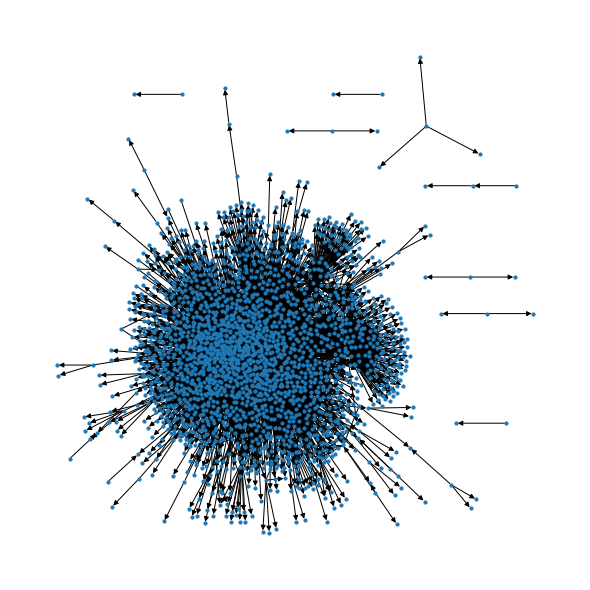

In [2]:
G_proteins = nx.read_edgelist('maayan-figeys/out.maayan-figeys',
                               comments='%', nodetype=int, create_using=nx.DiGraph)
G_proteins = nx.convert_node_labels_to_integers(G_proteins)
A_proteins = nx.adjacency_matrix(G_proteins).astype(np.float32).todense()
A_proteins = torch.from_numpy(A_proteins)

plt.figure(figsize=(8, 8))
pos = graphviz_layout(G_proteins, prog='sfdp')
nx.draw(G_proteins, pos=pos, node_size=10)

10000it [01:06, 150.34it/s, elbo=3.23e+4, kl=1.11e+3]


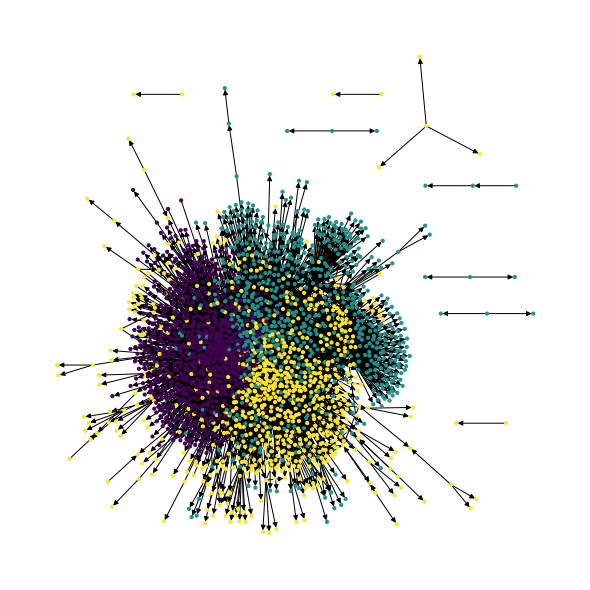

In [3]:
K = 3
# Set our priors
c = torch.zeros(A_proteins.shape[0], K)
mu = torch.eye(K)
sigma = torch.tensor(0.1)

model = VBSBM(c, mu, sigma, use_vi=True, use_degree_correction=True)

model.cuda()
A_proteins = A_proteins.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
pb = tqdm()
for i in range(10000):
    optimizer.zero_grad()
    elbo = -model(A_proteins)
    elbo.backward()
    optimizer.step()
    pb.set_postfix({'elbo': elbo.item(), 'kl': model.kl().item()})
    pb.update(1)
pb.close()
model.cpu()
A_proteins = A_proteins.cpu()

colors = (np.linspace(0, 1, K) * 20 + 10)
c = torch.argmax(model.c, dim=1).numpy()

plt.figure(figsize=(8, 8))
nx.draw(G_proteins, pos=pos, node_color=np.array([colors[block] for block in c]), node_size=10)